In [2]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# LIAR dataset

### Data preprocessing

In [8]:
from sklearn.naive_bayes import MultinomialNB

train_path = 'LIAR/train.tsv'
train_data = pd.read_csv(train_path,sep='\t', header=None, names=["id", "label", "statement", "subject(s)", "speaker","speaker's job title", "state info", "party affiliation", "barely true counts", "false counts","half true counts", "mostly true counts", "pants on fire counts", "context"])

train_data['label'] = train_data['label'].replace(['pants-fire', 'barely-true','false'], 0)
train_data['label'] = train_data['label'].replace(['half-true', 'mostly-true','true'], 1)




### Sentiment analysis

In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
def analyze_sentiment(text):
    if isinstance(text, str) == False and text != 'NaN':
        return None
    words = word_tokenize(text)
   
    # filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(words)

    sentiment_scores = sid.polarity_scores(filtered_text) 
    return sentiment_scores['compound'] +1

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
train_data['sentiment'] = train_data['statement'].apply(analyze_sentiment)
train_features = train_data[['sentiment', 'statement']]
y_train = train_data['label']
train_features.head()

,sentiment,statement
0,1.2500,Says the Annies List political group supports ...
1,1.3612,When did the decline of coal start? It started...
2,1.3182,"Hillary Clinton agrees with John McCain ""by vo..."
3,1.7579,Health care reform legislation is likely to ma...
4,1.0000,The economic turnaround started at the end of ...


### Creating model

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

vectorizer = TfidfVectorizer()
X_train_statement = vectorizer.fit_transform(train_features['statement'])
X_train_sentiment = sparse.csr_matrix(train_features['sentiment'].values.reshape(-1, 1))
X_train_features = sparse.hstack((X_train_statement, X_train_sentiment))

### Training Naive Bayes

In [11]:
nb_combined_model = MultinomialNB()
nb_combined_model.fit(X_train_features, y_train)

nb_statement_model = MultinomialNB()
nb_statement_model.fit(X_train_statement, y_train)

nb_sentiment_model = MultinomialNB()
nb_sentiment_model.fit(X_train_sentiment, y_train)

MultinomialNB()

### Cross Validating 

In [12]:
valid_path = 'LIAR/valid.tsv'
valid_data = pd.read_csv(valid_path,sep='\t', header=None, names=["id", "label", "statement", "subject(s)", "speaker","speaker's job title", "state info", "party affiliation", "barely true counts", "false counts","half true counts", "mostly true counts", "pants on fire counts", "context"])

valid_data['label'] = valid_data['label'].replace(['pants-fire', 'barely-true','false'], 0)
valid_data['label'] = valid_data['label'].replace(['half-true', 'mostly-true','true'], 1)

valid_data['sentiment'] = valid_data['statement'].apply(analyze_sentiment)
valid_features = valid_data[['sentiment', 'statement']]
y_valid = valid_data['label']

In [13]:
X_valid_statement = vectorizer.transform(valid_data['statement'])
X_valid_sentiment = sparse.csr_matrix(valid_data['sentiment'].values.reshape(-1, 1))
X_valid_features = sparse.hstack((X_valid_statement, X_valid_sentiment))

### Validation results

In [14]:
from sklearn.metrics import accuracy_score
y_combined_pred = nb_combined_model.predict(X_valid_features)
combined_accuracy = accuracy_score(valid_data['label'], y_combined_pred)
print("Accuracy for combined features:", combined_accuracy)

y_statement_pred = nb_statement_model.predict(X_valid_statement)
statement_accuracy = accuracy_score(valid_data['label'], y_statement_pred)
print("Accuracy for statement features:", statement_accuracy)

y_sentiment_pred = nb_sentiment_model.predict(X_valid_sentiment)
sentiment_accuracy = accuracy_score(valid_data['label'], y_sentiment_pred)
print("Accuracy for sentiment features:", sentiment_accuracy)

Accuracy for combined features: 0.5973520249221184
Accuracy for statement features: 0.6012461059190031
Accuracy for sentiment features: 0.5202492211838006


### Testing model

In [15]:
test_path = 'LIAR/test.tsv'

test_data = pd.read_csv(test_path,sep='\t', header=None, names=["id", "label", "statement", "subject(s)", "speaker","speaker's job title", "state info", "party affiliation", "barely true counts", "false counts","half true counts", "mostly true counts", "pants on fire counts", "context"])

test_data['label'] = test_data['label'].replace(['pants-fire', 'barely-true','false'], 0)
test_data['label'] = test_data['label'].replace(['half-true', 'mostly-true','true'], 1)
test_data['sentiment'] = test_data['statement'].apply(analyze_sentiment)
test_features = test_data[['sentiment', 'statement']]
y_test = test_data['label']

In [16]:
X_test_statement = vectorizer.transform(test_data['statement'])
X_test_sentiment = sparse.csr_matrix(test_data['sentiment'].values.reshape(-1, 1))
X_test_features = sparse.hstack((X_test_statement, X_test_sentiment))

### Testing results

In [17]:
y_combined_pred_test = nb_combined_model.predict(X_test_features)
combined_accuracy_test = accuracy_score(test_data['label'], y_combined_pred_test)
print("Accuracy for combined features:", combined_accuracy_test)

y_statement_pred_test = nb_statement_model.predict(X_test_statement)
statement_accuracy_test = accuracy_score(test_data['label'], y_statement_pred_test)
print("Accuracy for statement features:", statement_accuracy_test)

y_sentiment_pred_test = nb_sentiment_model.predict(X_test_sentiment)
sentiment_accuracy_test = accuracy_score(test_data['label'], y_sentiment_pred_test)
print("Accuracy for sentiment features:", sentiment_accuracy_test)


Accuracy for combined features: 0.6006314127861089
Accuracy for statement features: 0.6045777426992897
Accuracy for sentiment features: 0.56353591160221


# Fake reddit dataset

In [20]:
fakeddit_train_path1 = 'Fakeddit/train1.tsv'
fakeddit_train_path2 = 'Fakeddit/train2.tsv'
fakeddit_train_path3 = 'Fakeddit/train3.tsv'

fakeddit_train_data1 = pd.read_csv(fakeddit_train_path1, sep='\t')
fakeddit_train_data2 = pd.read_csv(fakeddit_train_path2, sep='\t')
fakeddit_train_data3 = pd.read_csv(fakeddit_train_path3, sep='\t')
fakeddit_train_data = pd.concat([fakeddit_train_data1, fakeddit_train_data2, fakeddit_train_data3], ignore_index=True)
fakeddit_train_data = fakeddit_train_data[fakeddit_train_data['clean_title'].notna()]
fakeddit_train_data['sentiment'] = fakeddit_train_data['clean_title'].apply(analyze_sentiment) 


In [21]:
vectorizer_fakeddit = TfidfVectorizer()
X_train_statement_fakeddit = vectorizer_fakeddit.fit_transform(fakeddit_train_data['clean_title'])
X_train_sentiment_fakeddit = sparse.csr_matrix(fakeddit_train_data['sentiment'].values.reshape(-1, 1))
X_train_features_fakeddit = sparse.hstack((X_train_statement_fakeddit, X_train_sentiment_fakeddit))

In [22]:
nb_combined_model_fakeddit =  MultinomialNB()
nb_combined_model_fakeddit.fit(X_train_features_fakeddit, fakeddit_train_data['2_way_label'])

nb_title_model_fakeddit = MultinomialNB()
nb_title_model_fakeddit.fit(X_train_statement_fakeddit, fakeddit_train_data['2_way_label'])

nb_sentiment_model_fakeddit = MultinomialNB()
nb_sentiment_model_fakeddit.fit(X_train_sentiment_fakeddit, fakeddit_train_data['2_way_label'])

MultinomialNB()

In [23]:
fakeddit_valid_path = 'Fakeddit/all_validate.tsv'
fakeddit_valid_data = pd.read_csv(fakeddit_valid_path, sep='\t')
fakeddit_valid_data = fakeddit_valid_data[fakeddit_valid_data['clean_title'].notna()]
fakeddit_valid_data['sentiment'] = fakeddit_valid_data['clean_title'].apply(analyze_sentiment)

In [24]:
X_valid_statement_fakeddit = vectorizer_fakeddit.transform(fakeddit_valid_data['clean_title'])
X_valid_sentiment_fakeddit = sparse.csr_matrix(fakeddit_valid_data['sentiment'].values.reshape(-1, 1))
X_valid_features_fakeddit = sparse.hstack((X_valid_statement_fakeddit, X_valid_sentiment_fakeddit))

In [25]:
y_combined_pred_fakeddit = nb_combined_model_fakeddit.predict(X_valid_features_fakeddit)
combined_accuracy_fakeddit = accuracy_score(fakeddit_valid_data['2_way_label'], y_combined_pred_fakeddit)
print("Accuracy for combined features:", combined_accuracy_fakeddit)

y_statement_pred_fakeddit = nb_title_model_fakeddit.predict(X_valid_statement_fakeddit)
statement_accuracy_fakeddit = accuracy_score(fakeddit_valid_data['2_way_label'], y_statement_pred_fakeddit)
print("Accuracy for statement features:", statement_accuracy_fakeddit)

y_sentiment_pred_fakeddit = nb_sentiment_model_fakeddit.predict(X_valid_sentiment_fakeddit)
sentiment_accuracy_fakeddit = accuracy_score(fakeddit_valid_data['2_way_label'], y_sentiment_pred_fakeddit)
print("Accuracy for sentiment features:", sentiment_accuracy_fakeddit)


Accuracy for combined features: 0.7891430869688654
Accuracy for statement features: 0.7856771079776663
Accuracy for sentiment features: 0.5017389041355163


### Re training on full data

In [29]:
fakeddit_full_data = pd.concat([fakeddit_train_data, fakeddit_valid_data], ignore_index=True)
full_vectorizer = TfidfVectorizer()
X_full_statement = full_vectorizer.fit_transform(fakeddit_full_data['clean_title'])
X_full_sentiment = sparse.csr_matrix(fakeddit_full_data['sentiment'].values.reshape(-1, 1))
X_full_features = sparse.hstack((X_full_statement, X_full_sentiment))

In [30]:
fakeddit_nb_full_model =  MultinomialNB()
fakeddit_nb_full_model.fit(X_full_features, fakeddit_full_data['2_way_label'])

MultinomialNB()

### Testing 

In [31]:
fakeddit_test_path = 'Fakeddit/coda_text.csv'
fakeddit_test_data = pd.read_csv(fakeddit_test_path)
fakeddit_test_data = fakeddit_test_data[fakeddit_test_data['clean_title'].notna()]
fakeddit_test_data['sentiment'] = fakeddit_test_data['clean_title'].apply(analyze_sentiment)    
fakeddit_test_data.head()

,clean_title,id,sentiment
0,rex roar,b4afd746dd,1.0
1,other discussions,ff802e9957,1.0
2,keeping an eye on the class,8aa68d331f,1.0
3,fixed it for you,a1e3054072,1.0
4,til of hitchbot a robot designed to turn its b...,55bba1a2ba,1.0


In [32]:
fakeddit_full_predictions = fakeddit_nb_full_model.predict(fakeddit_test_data)
fakeddit_full_accuracy = accuracy_score(fakeddit_full_data['2_way_label'], fakeddit_full_predictions)
print("Accuracy for full features:", fakeddit_full_accuracy)

Accuracy for full features: 0.8149652044065027


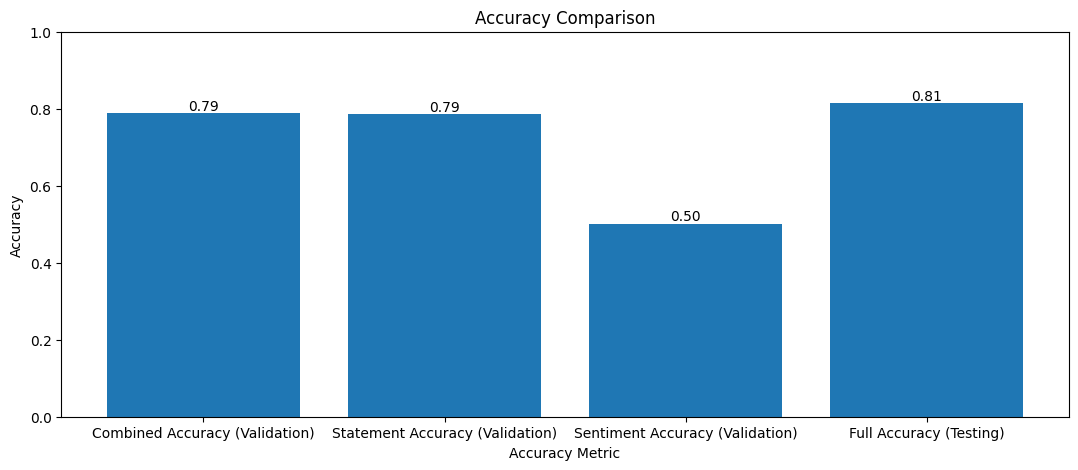

In [45]:
from matplotlib import pyplot as plt

accuracy_scores = {'Combined Accuracy (Validation)': combined_accuracy_fakeddit, 'Statement Accuracy (Validation)': statement_accuracy_fakeddit, 'Sentiment Accuracy (Validation)': sentiment_accuracy_fakeddit, 'Full Accuracy (Testing)': fakeddit_full_accuracy}

plt.figure(figsize=(13, 5)) 
bars  = plt.bar(accuracy_scores.keys(), accuracy_scores.values())
plt.xlabel('Accuracy Metric')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim(0, 1)  
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height:.2f}', ha='center', va='bottom')

plt.show()